In [1]:
%matplotlib widget
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

Data prep

In [2]:
df = pd.read_csv('datasets/PJME_hourly.csv')
# print(df.head())
# print(df.tail())
df = df.set_index('Datetime')     # setting Datetime as index(we no longer have column with index)
# print(df.head())
# print(df.tail())
df.index = pd.to_datetime(df.index) # formatting datetime as date format
# df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy use in MW')

Visualizing Train / Test split

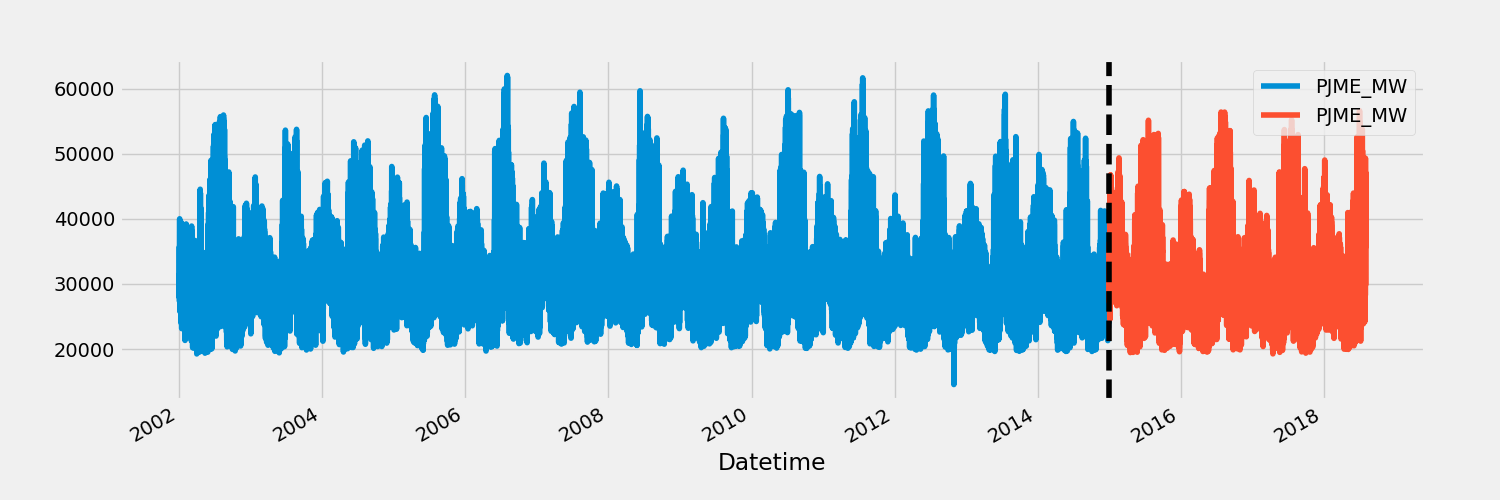

In [3]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Training set')
ax.axvline('01-01-2015', color='black', ls='--')

Outlier Removal

<AxesSubplot:xlabel='Datetime'>

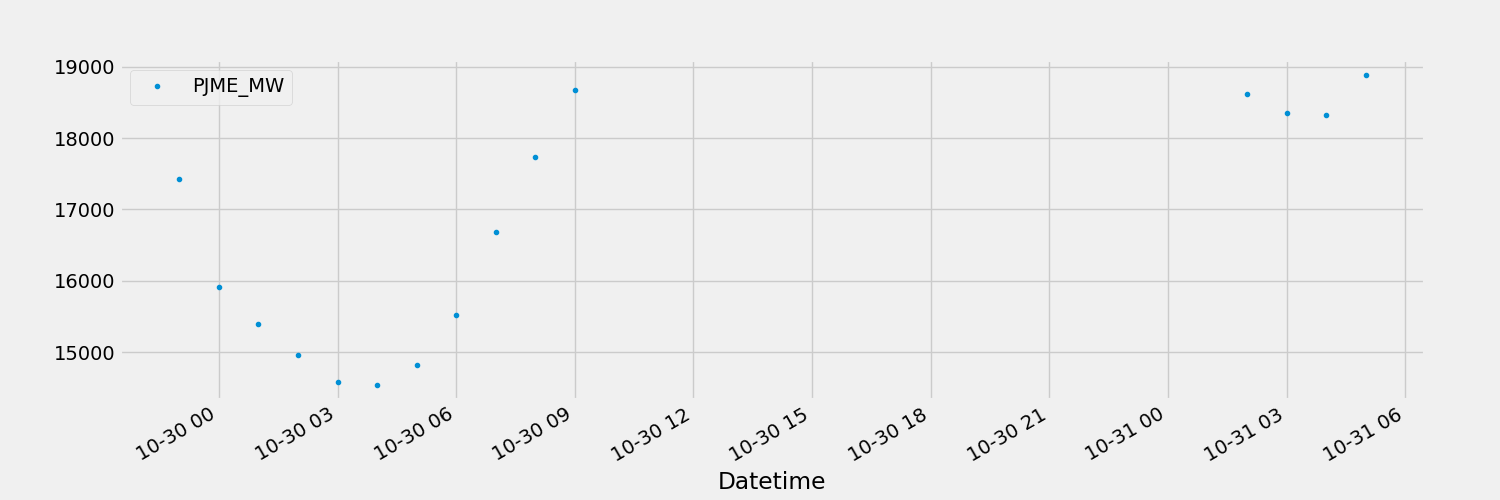

In [4]:
df.query('PJME_MW < 19000').plot(figsize=(15,5), style='.')

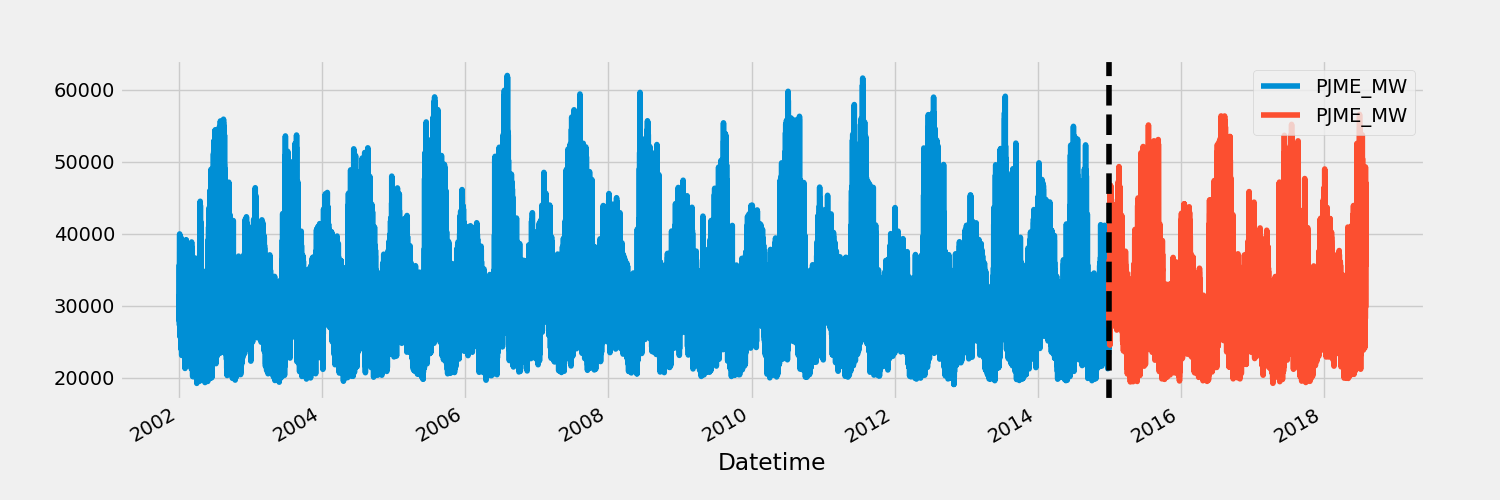

In [5]:
df = df.query('PJME_MW > 19000').copy() # Outlier filtered

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Training set')
ax.axvline('01-01-2015', color='black', ls='--')

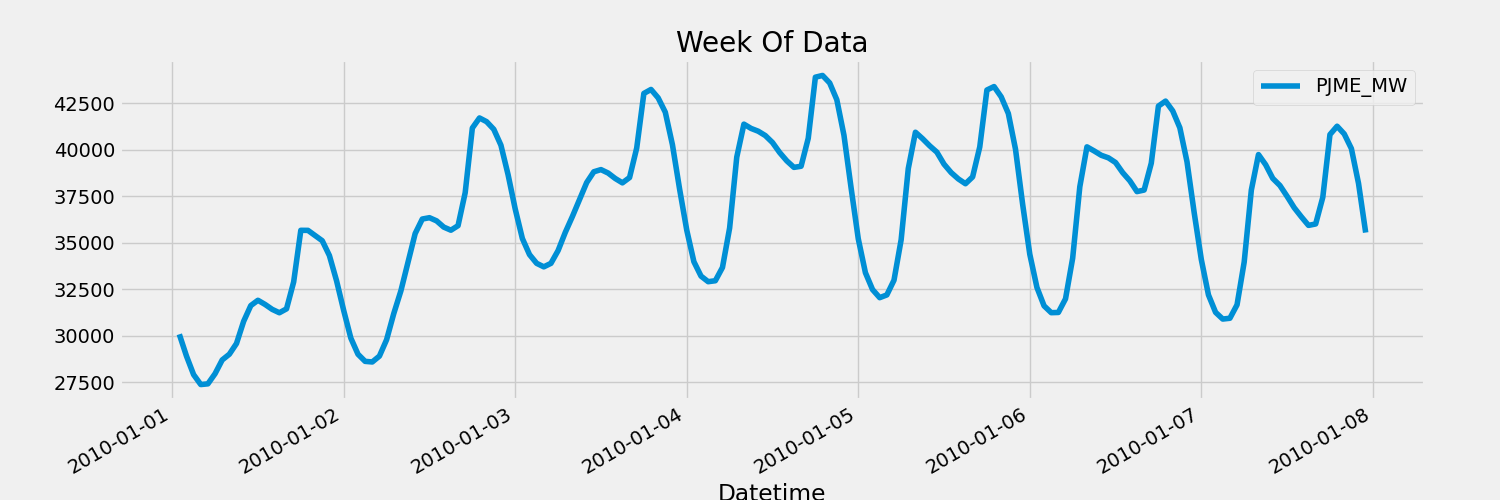

In [6]:
# Visualizing only one week of data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Time series cross validation

In [7]:
from sklearn.model_selection import TimeSeriesSplit

In [8]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #5 years, predicting hourly for 1 year, 24 hours
df = df.sort_index() # need to sort time series or it will not work

for train_idx, val_idx in tss.split(df):
    break

In [9]:
train_idx

array([     0,      1,      2, ..., 101524, 101525, 101526])

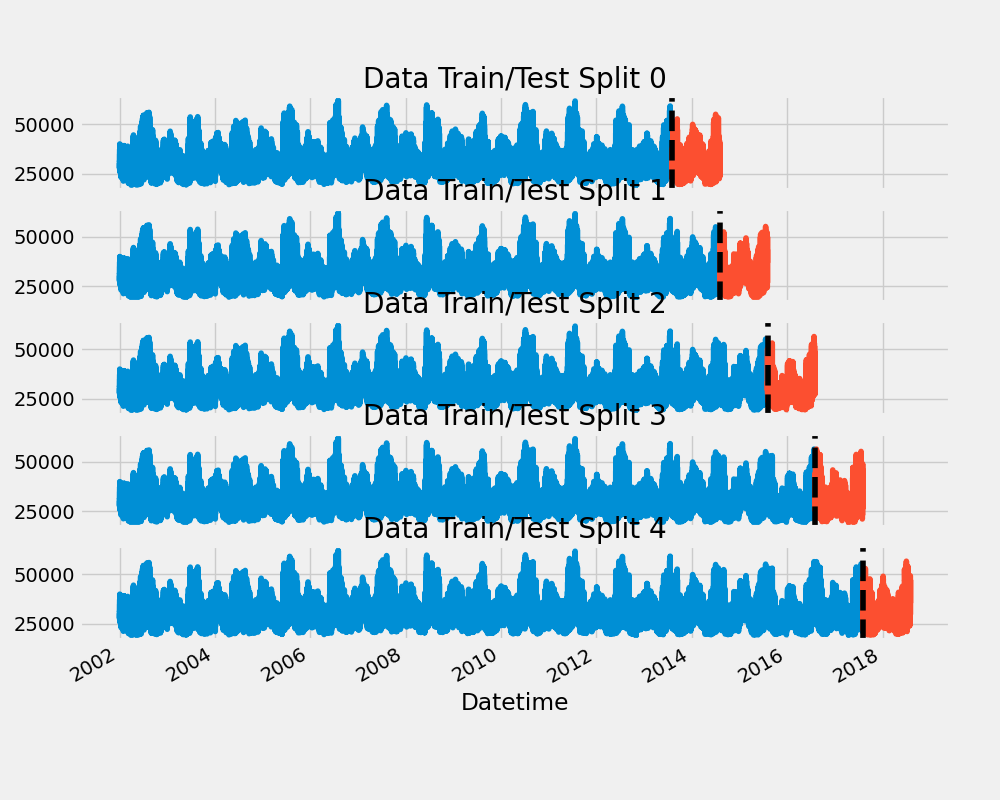

In [10]:
fig,ax = plt.subplots(5,1, figsize=(10,8),
                            sharex=True)               # sharing x axis x axis is the same
fold = 0                                                # we track our fold (could be done with enumerate)
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=ax[fold], label='Training set', title=f'Data Train/Test Split {fold}')
    test['PJME_MW'].plot(ax=ax[fold], label='Test set')
    ax[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term (more than 2 years)

Feature creation   

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# 3. Lag features

 - What was the target (x) days in the past.

In [12]:
target_map = df['PJME_MW'].to_dict()

In [13]:
def add_lags(df):
    df['lag_1_year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2_year'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3_year'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag_1_year,lag_2_year,lag_3_year
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN


In [16]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag_1_year,lag_2_year,lag_3_year
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


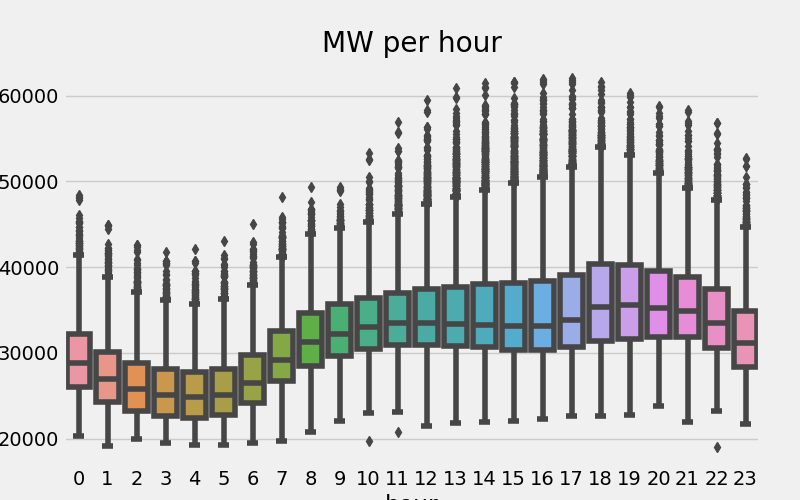

In [56]:
# Visualizing feature vs target relationship
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
plt.title('MW per hour')
# print(df.columns)
# ['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth', 'weekofyear']
plt.show()

# Train using cross validation

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 
                'month', 'year', 'lag_1_year','lag_2_year','lag_3_year']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

# CREATING XGBoost regressor model

    reg = xgb.XGBRegressor(base_score =0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,            # model will stop after 50 trees
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Scoring all folds and saving it to a list 'scores'

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[400]	validation_0-rmse:3476.76871	validation_1-rmse:3598.75393
[500]	validation_0-rmse:3355.49568	validation_1-rmse:3530.19662
[600]	validation_0-rmse:3298.89678	validation_1-rmse:3492.70060
[700]	validation_0-rmse:3258.68974	validation_1-rmse:3468.00301
[800]	validation_0-rmse:3224.41851	validation_1-rmse:3446.84051
[900]	validation_0-rmse:3196.68131	v

In [26]:
# The loop scored on 5 folds, these are the scores saved to a list
print(f'Score across folds: {np.mean(scores)}')
print(f'Individual scores: {scores}')

Score across folds: 3753.5993914714295
Individual scores: [3757.485267269142, 3422.628654218696, 3473.0621874794947, 4115.966281700851, 3998.8545666889618]


# 4. Predicting the future

- First re-train the model on all data
- Predict the future - you will need an an empty dataframe for future date ranges
- Run those dates through our feature creation code + lag creation

In [27]:
# Before we created the x and y value from the train and validation separately. 
# Now, the features will be created on all our data

df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 
            'month', 'year', 'lag_1_year','lag_2_year','lag_3_year']
TARGET = 'PJME_MW'
    
X_all = df[FEATURES]
y_all = df[TARGET]

# CREATING XGBoost regressor model

reg = xgb.XGBRegressor(base_score =0.5, booster='gbtree',
                       n_estimators=500,                #different than before due to overfitting after 500th iter
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [30]:
df.index.min()

Timestamp('2002-01-01 01:00:00')

In [57]:
# Create future dataframe, hourly time stamp

future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index = future)

# Create isFuture column for both dfs to verify if a given row is a future date or not
future_df['isFuture'] = True
df['isFuture'] = False

# Concatenate the two dfs
df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [58]:
future_w_features = df_and_future.query('isFuture').copy()

# Predicting the future

In [75]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
# future_w_features.tail()

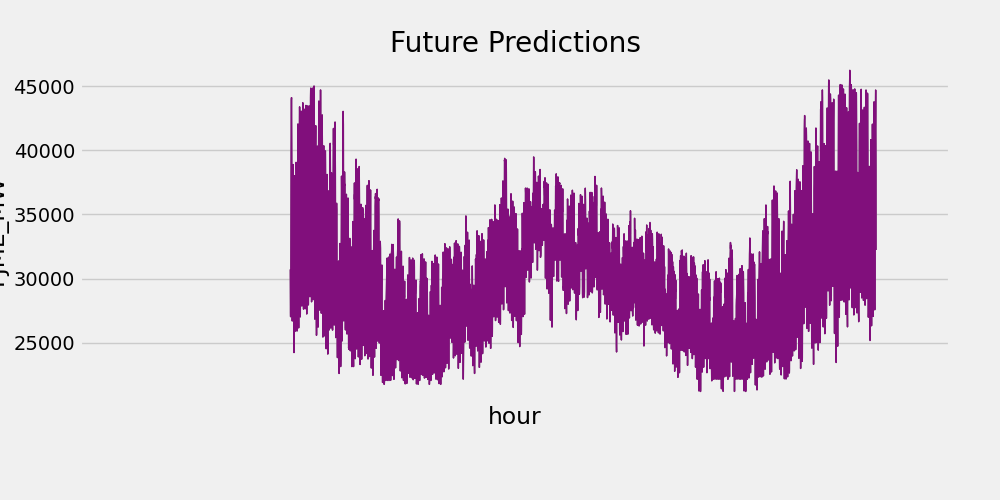

In [61]:
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[5],
                               ms=1, lw=1,
                               title = 'Future Predictions')
plt.show()

Feature importance (manual)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


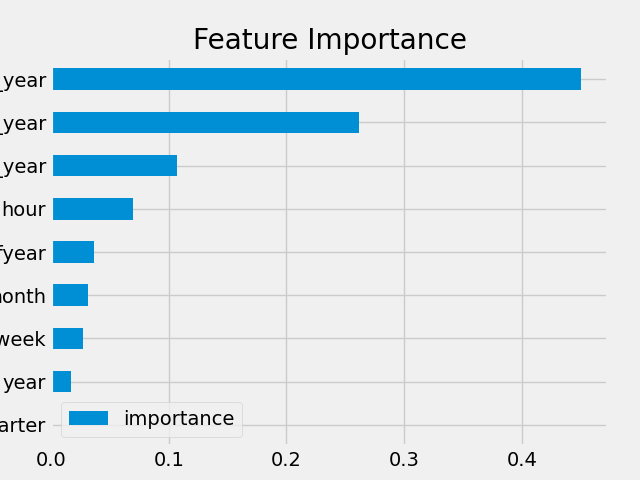

In [68]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Feature importance with SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


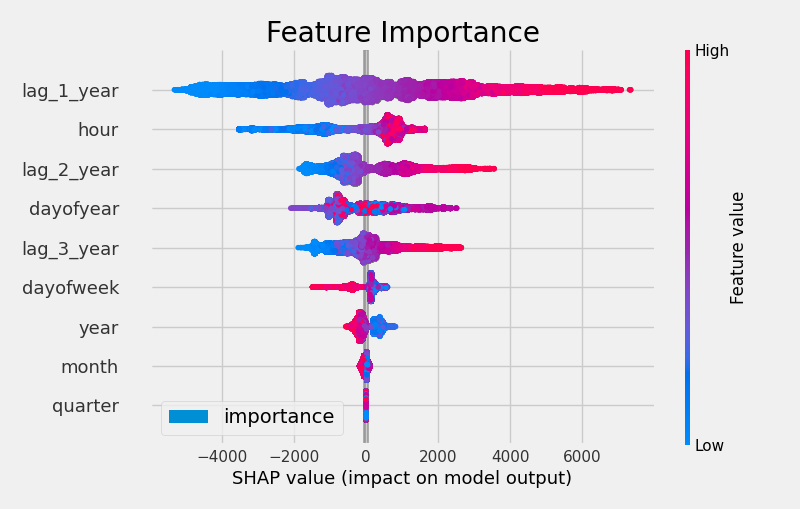

In [67]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train) # plot_type='bar')

Forecast on the test set

In [69]:
print(reg.predict(X_test))

[28390.65  27607.994 26822.977 ... 38970.703 36722.664 30716.518]


In [70]:
predictions = reg.predict(X_test)
# RMSE  
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print('The RMSE for the model is: %.2f' % rmse)

The RMSE for the model is: 3769.52


Plotting - since 2015

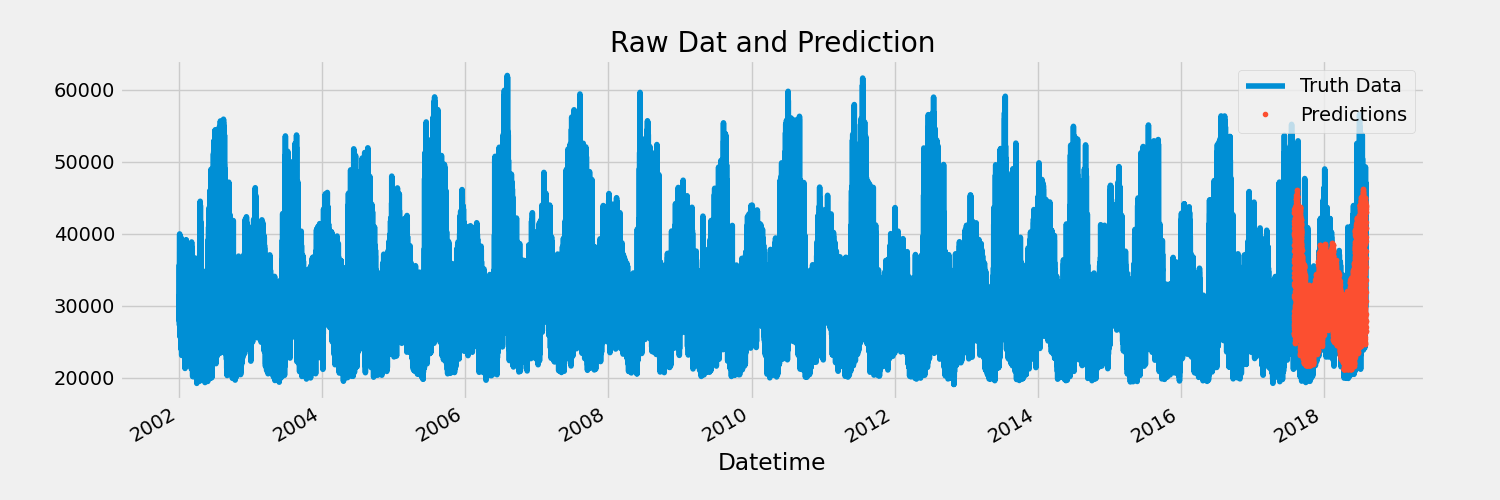

In [71]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

Plotting - one week

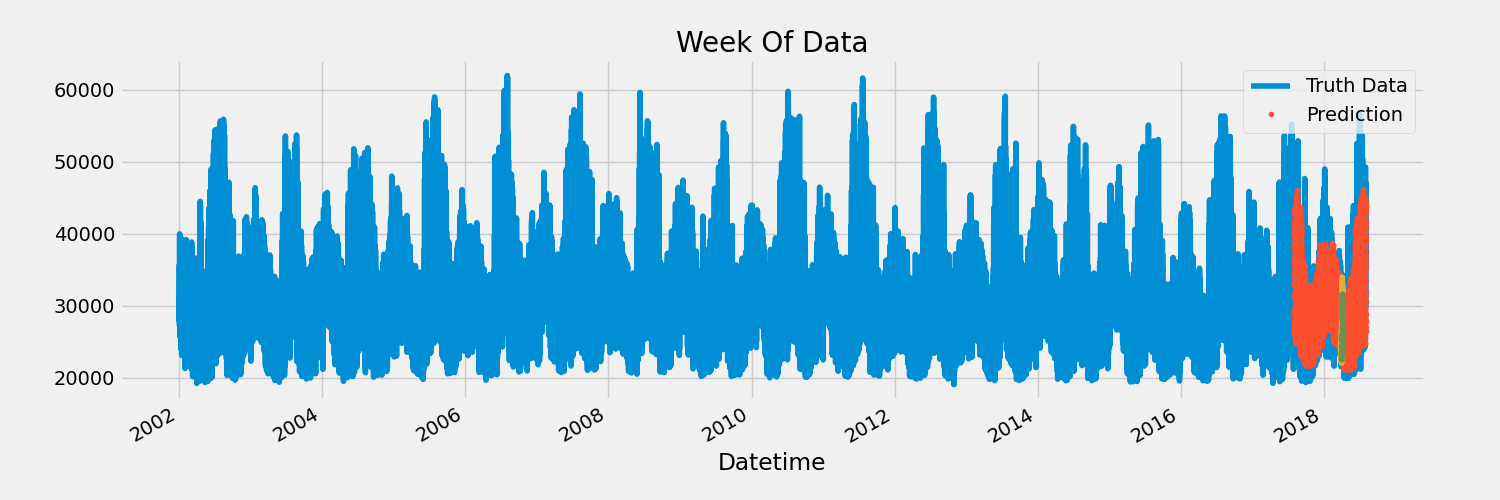

In [72]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Calculate the highest and the lowest errors

In [73]:
test['error'] = np.abs(test[TARGET] - test['prediction']) #absolute value
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    10332.387370
2018-07-02    10245.950114
2017-12-31    10152.640951
2018-01-05     9642.779297
2018-07-03     8857.708740
2017-08-29     8792.238444
2018-07-01     8709.274251
2018-01-07     8514.982829
2017-09-01     8423.220052
2017-12-28     8243.262695
Name: error, dtype: float64

In [74]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2018-04-25    248.518229
2017-12-03    294.974447
2018-05-22    369.708252
2017-10-13    473.560628
2017-12-08    475.312256
2017-11-16    509.965251
2018-05-06    511.903483
2017-10-12    539.697266
2018-02-24    567.397380
2018-03-29    614.856038
Name: error, dtype: float64